In [25]:
import collections
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from cbc_paths import file_path_csv, file_path_image
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
lemma = nltk.wordnet.WordNetLemmatizer()
import numpy as np
from PIL import Image

# Get current url
file = os.path.abspath('') + '\cbc_stories.json'
with open(file) as json_file:
    cbc_stories = json.load(json_file)

cbc_url = ([x for x in cbc_stories if x['retrieval_status'] == 'pending'])[0]['url']
print(cbc_url)

# Create file name variable from url
file_name = cbc_url.replace('https://www.cbc.ca/','').replace('news/','').replace('sports/','').replace('/','_')

# Read csv file into df
df = pd.read_csv(file_path_csv + file_name + '.csv') #, encoding='utf-8'

# Drop null comment text df records for both word clouds and networkx viz
df.dropna(subset=['comment_text'], how='all', inplace=True)
print(len(df))

https://www.cbc.ca/radio/thehouse/cbc-the-house-feb-19-1.6356836
2282


In [26]:
# Create comment word text word cloud viz

# Combine comment_text into list of comments
text_list = df['comment_text'].tolist()

# Combine all comment text into one huge text
text = ' '.join(comment.lower() for comment in df.comment_text)

# Clean up comment text
stop_words = set(stopwords.words('english'))
punctuation = list(punctuation)
tokens = word_tokenize(text)
filtered_text1 = [token for token in tokens if token not in stop_words]
filtered_text2 = [idx for idx in filtered_text1 if not any(punc in idx for punc in string.punctuation)]
filtered_text3 = [item for item in filtered_text2 if len(item)>1]
filtered_text4 = [x for x in filtered_text3 if not isinstance(x, int)]
filtered_text = [lemma.lemmatize(x) for x in filtered_text4]

# Print summary
print(cbc_url)
print(file_name)
print('filtered_text len:', len(filtered_text))

https://www.cbc.ca/radio/thehouse/cbc-the-house-feb-19-1.6356836
radio_thehouse_cbc-the-house-feb-19-1.6356836
filtered_text len: 21721


https://www.cbc.ca/radio/thehouse/cbc-the-house-feb-19-1.6356836


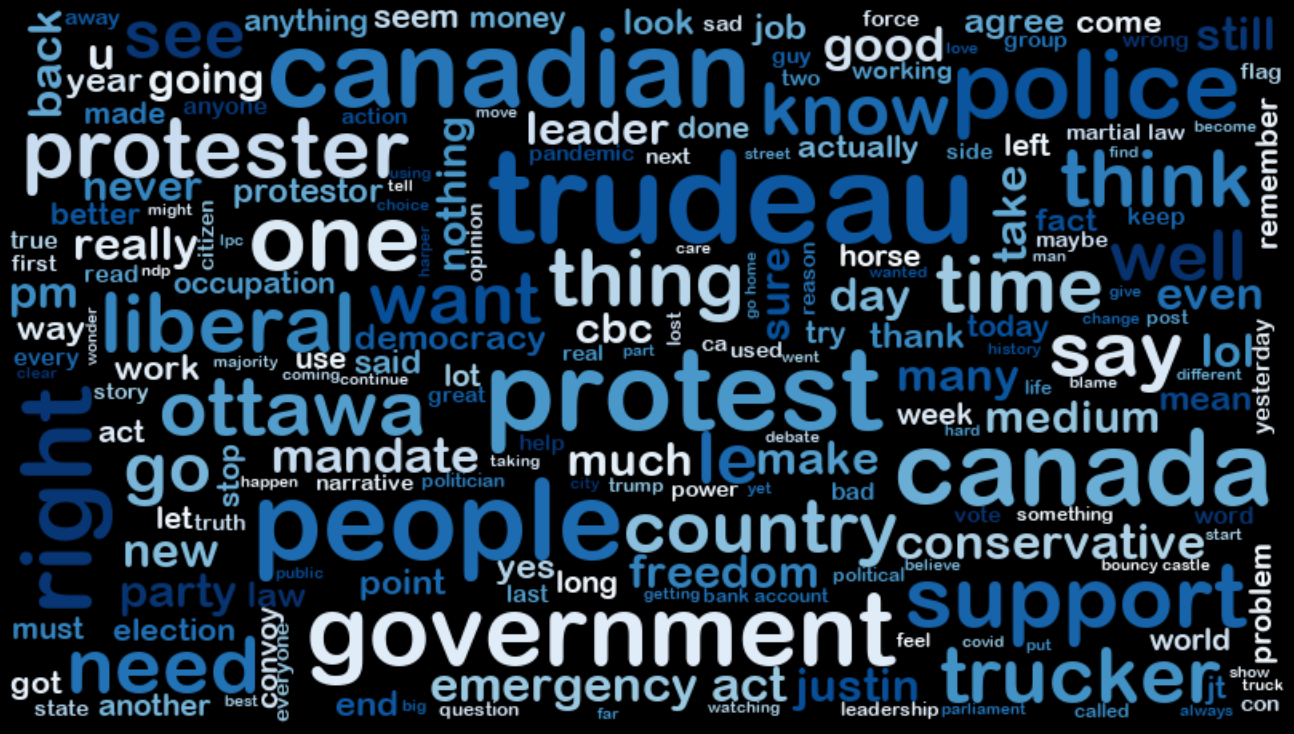

In [27]:
# Create comment word cloud viz

# optionally can apply mask image to wordcloud
#mask = np.array(Image.open(file_path_image + '/mask_china.jpg'))

print(cbc_url)
wordcloud = WordCloud(
    width=800, 
    height=450,
    font_path='c:/windows/font/ARLRDBD.TTF',
    #mask=mask,
    colormap='Blues',
    max_font_size=80,
    collocations=True, 
    max_words=200, 
    background_color='black'
    ).generate(' '.join(filtered_text))

plt.figure(
    figsize=(20,10), 
    facecolor='k'
    )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Save the image in the img folder:
wordcloud.to_file(file_path_image + 'word_cloud_' + file_name + '.png')

In [28]:
# Create people word cloud viz

# Combine comment_user's into list
people_list = df['comment_user'].tolist()

# print summary
print(cbc_url)
print(file_name)
print('people_list len:', len(people_list), 'people_list[:10]:', people_list[:10])

https://www.cbc.ca/radio/thehouse/cbc-the-house-feb-19-1.6356836
radio_thehouse_cbc-the-house-feb-19-1.6356836
people_list len: 2282 people_list[:10]: ['John Cogg', 'Jack Ruler', 'Norm Aikman', 'Bryan Atkinson', 'John Cogg', 'Johnny Roberts', 'Jason Barra', 'James Brown', 'Bort Smith', 'John Cogg']


https://www.cbc.ca/radio/thehouse/cbc-the-house-feb-19-1.6356836


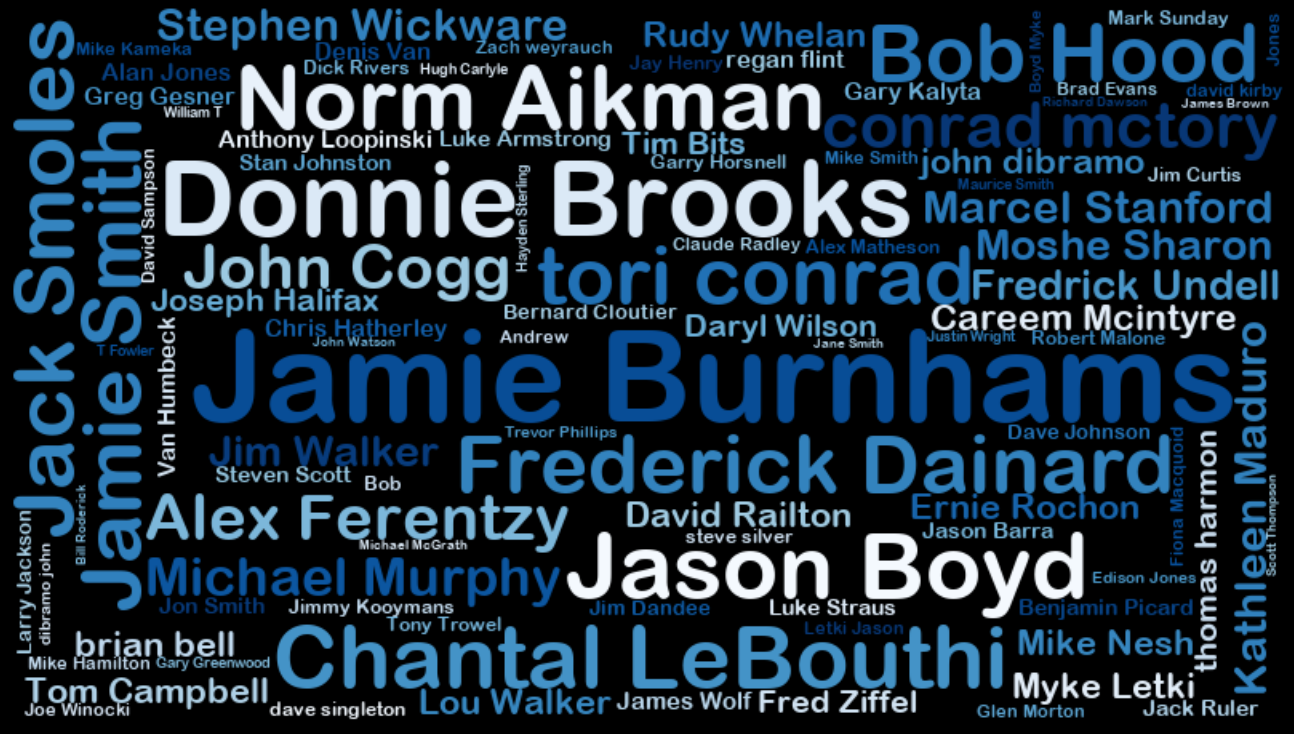

In [29]:
# Create wordcloud
print(cbc_url)
wordcloud = WordCloud(
    width=800, 
    height=450,
    font_path='c:/windows/font/ARLRDBD.TTF',
    colormap='Blues',
    max_font_size=80,
    collocations=True, 
    max_words=100, 
    background_color='black'
    ).generate(' '.join(people_list))

plt.figure(
    figsize=(20,10), 
    facecolor='k'
    )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Save the image in the img folder:
wordcloud.to_file(file_path_image + 'people_' + file_name + '.png')

https://www.cbc.ca/radio/thehouse/cbc-the-house-feb-19-1.6356836
G.nodes(): 230 factor: 1.5165750888103102 w & h: 37.914377220257755 37.914377220257755


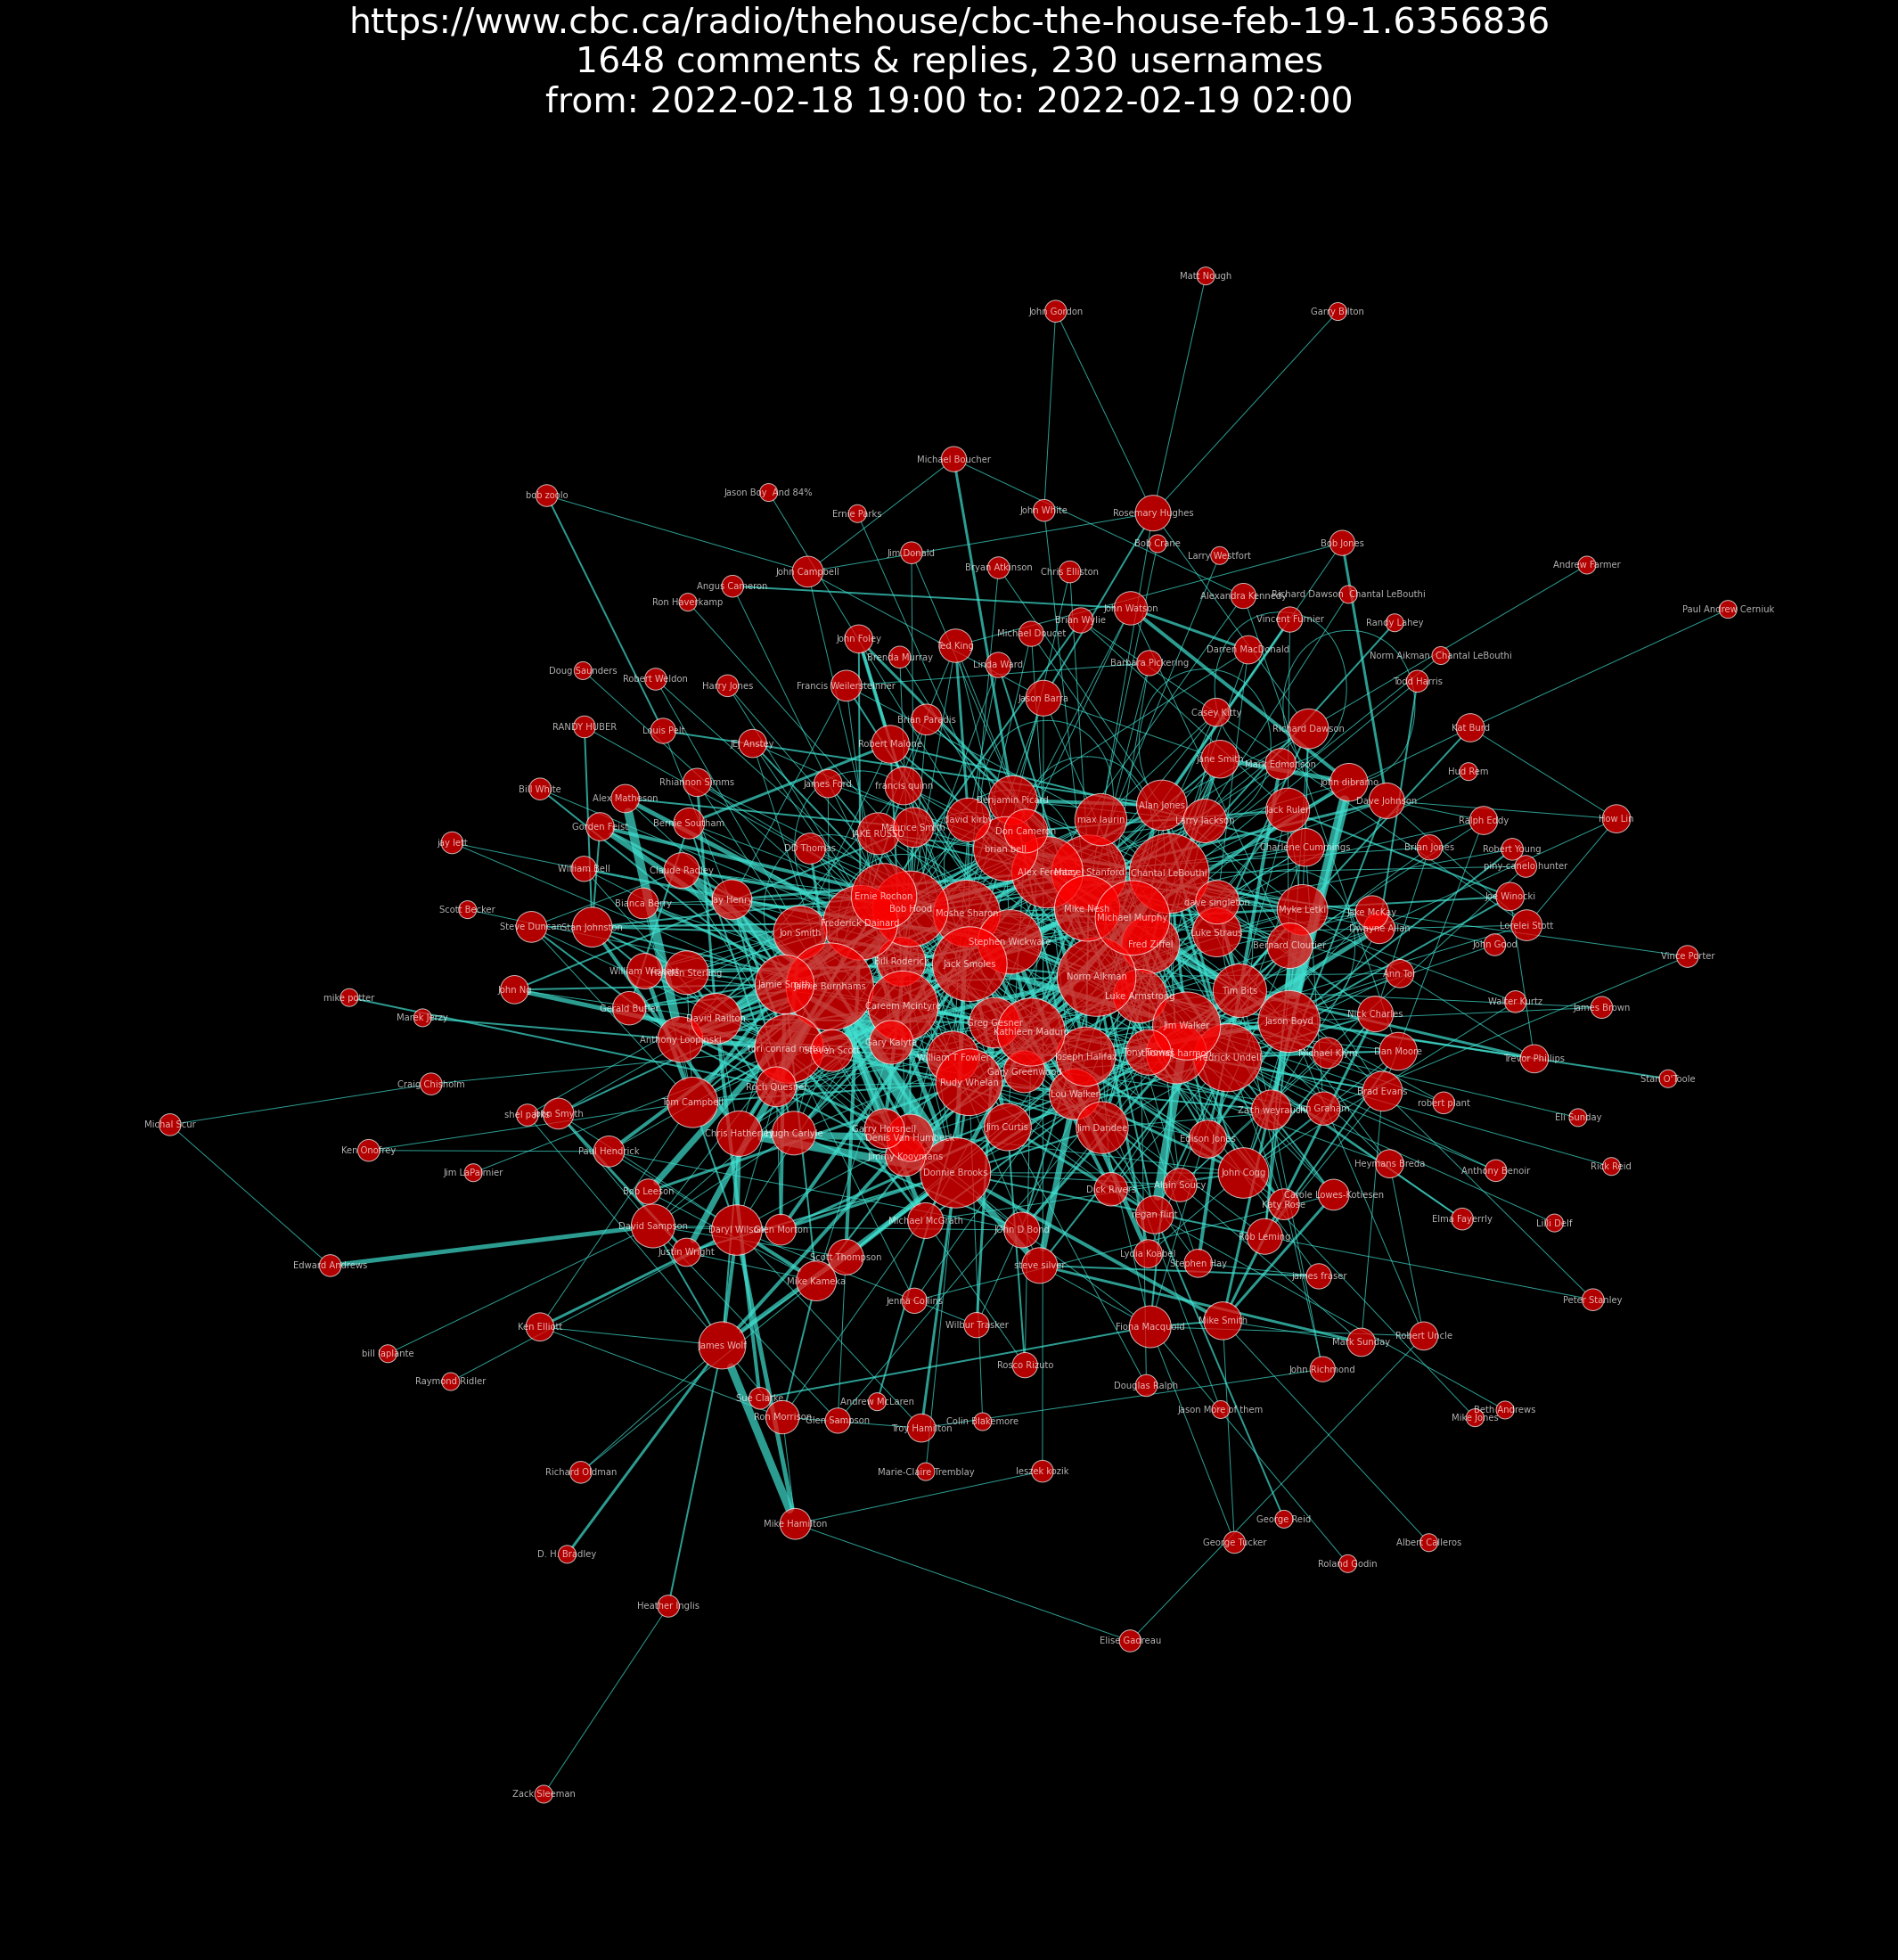

In [30]:
# Create networkx viz

import networkx as nx
import pydot # optional connector for graphviz
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import math

print(cbc_url)
# Drop comments without any replies
df.dropna(subset=['replied_to_user'], how='all', inplace=True)
df1 = df[['comment_user', 'replied_to_user']]
df2= (
    df1.groupby(df1.apply(lambda x: tuple(sorted(x)), axis=1))
    .agg(comment_user=("comment_user", "first"), replied_to_user=("replied_to_user", "first"), counts=("replied_to_user", "size"))
    .reset_index(drop=True)
)

# Build NetworkX graph
G = nx.Graph()

# Select data to use in graph from dataframe with full data
G = nx.from_pandas_edgelist(df2, 'comment_user', 'replied_to_user', 'counts')

# Create node size variable
d = nx.degree(G)

# Create weights list for edge colors
#weights = df_no_replies['minutes'].tolist()
edges, counts = zip(*nx.get_edge_attributes(G,'counts').items())

# https://matplotlib.org/stable/tutorials/colors/colormaps.html
# https://matplotlib.org/stable/gallery/color/named_colors.html
factor = math.sqrt(len(G.nodes()) * 0.01)

# Create plot
plt_width = 25 * factor
plt_height = 25 * factor
fig, ax = plt.subplots(figsize=(plt_width, plt_height))
fig.set_facecolor('black')
ax.set_facecolor('black')

# Choose layout
#pos = nx.spring_layout(G, k=0.1, iterations=10)
#pos = nx.spring_layout(G)
pos = nx.kamada_kawai_layout(G)
#pos = nx.nx_pydot.graphviz_layout(G, prog='neato')
#pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
#pos = nx.nx_pydot.graphviz_layout(G, prog='circo')
#pos = nx.nx_pydot.graphviz_layout(G, prog='fdp')
#pos = nx.nx_pydot.graphviz_layout(G, prog='sfdp')
#pos = nx.nx_pydot.graphviz_layout(G, prog='twopi')

# orginal draw method all in one (see bottom cell for separated draw method)
nx.draw_networkx(
    G, 
    pos,
    ## nodes
    node_color='red',
    alpha=0.7,
    edgecolors='white', #color of node border
    node_size=[(d[node]+1) * 200 for node in G.nodes()],
    linewidths=1.0, #width of node border
    ## labels
    with_labels=True,
    font_color='white',
    font_size=10,
    font_family='sans-serif', 
    font_weight='normal',
    horizontalalignment='center', 
    verticalalignment='center', 
    ## edges
    edgelist=edges,
    edge_color='turquoise',
    #edge_cmap=plt.cm.spring, 
    width=counts, #1.0, #width of edge
    arrows=True,
    arrowsize=0,
    arrowstyle='|-|',
)

# Create variables to use in chart title
min_comment_time = df['comment_time'].min()[:-3]
max_comment_time = df['comment_time'].max()[:-3]
comment_count = len(df)

# Create chart title text
title_text = cbc_url + '\n' + str(comment_count) + ' comments & replies, ' + str(len(G.nodes())) + ' usernames' + '\n' + 'from: ' + min_comment_time + ' to: ' + max_comment_time

# Add chart title
plt.title(title_text, fontsize=26 * factor, color='white')
plt.axis("off")

# Save the image in the img folder:
plt.savefig(file_path_image + 'network_' + file_name + '.png', format="PNG")

# Print image details
print('G.nodes():', len(G.nodes()), 'factor:', factor, 'w & h:', plt_width, plt_height)

In [31]:
# Not used for word cloud just used to get word frequency
frequency = collections.Counter(people_list)
frequency_sorted = sorted(frequency.items(), key=lambda kv: kv[1], reverse=True)
print(frequency_sorted[:10])

[('Jamie Burnhams', 96), ('Donnie Brooks', 63), ('Jason Boyd', 48), ('Norm Aikman', 45), ('Chantal LeBouthi', 45), ('Jack Smoles', 42), ('Jamie Smith', 41), ('Frederick Dainard', 40), ('Bob Hood', 40), ('tori conrad mctory', 40)]


In [32]:

# Unused - edges, nodes, labels as separate steps method
'''
# draw edges
nx.draw_networkx_edges(
    G, 
    pos,
    arrows=False,
    arrowsize=20,
    edgelist=edges,
    edge_color=counts,
    width=counts,
    edge_cmap=plt.cm.spring,
    node_size=[(d[node]+1) * 200 for node in G.nodes()], # tells edge to go join node on border
)

# draw nodes
nx.draw_networkx_nodes(
    G, 
    pos,
    node_color='red',
    alpha = 0.7,
    edgecolors='white', #color of node border
    node_size=[(d[node]+1) * 200 for node in G.nodes()],
)

# draw labels
nx.draw_networkx_labels(
    G, 
    pos, 
    labels=None, 
    font_size=10, 
    font_color='white', 
    font_family='sans-serif', 
    font_weight='normal', 
    alpha=None, 
    bbox=None, 
    horizontalalignment='center', 
    verticalalignment='center', 
    ax=None, 
    clip_on=False
)
'''

"\n# draw edges\nnx.draw_networkx_edges(\n    G, \n    pos,\n    arrows=False,\n    arrowsize=20,\n    edgelist=edges,\n    edge_color=counts,\n    width=counts,\n    edge_cmap=plt.cm.spring,\n    node_size=[(d[node]+1) * 200 for node in G.nodes()], # tells edge to go join node on border\n)\n\n# draw nodes\nnx.draw_networkx_nodes(\n    G, \n    pos,\n    node_color='red',\n    alpha = 0.7,\n    edgecolors='white', #color of node border\n    node_size=[(d[node]+1) * 200 for node in G.nodes()],\n)\n\n# draw labels\nnx.draw_networkx_labels(\n    G, \n    pos, \n    labels=None, \n    font_size=10, \n    font_color='white', \n    font_family='sans-serif', \n    font_weight='normal', \n    alpha=None, \n    bbox=None, \n    horizontalalignment='center', \n    verticalalignment='center', \n    ax=None, \n    clip_on=False\n)\n"